# **Biometric Falcon Eye**
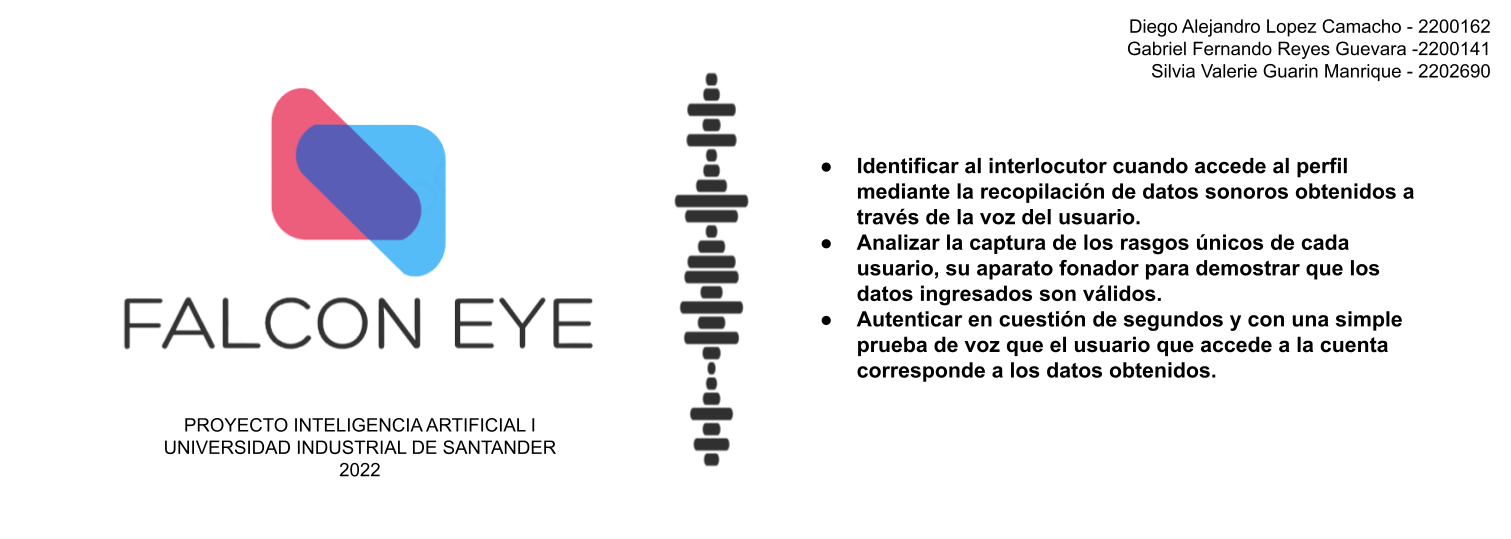


## **Integrantes**


*   **Diego Alejandro Lopez Camacho - 2200162 - Grupo H2** 
*   **Gabriel Fernando Reyes Guevara - 2200141 - Grupo J1**
*   **Silvia Valerie Guarin Manrique - 2202690 - Grupo H2**

### Descripcion del proyecto
La biometría por voz es una tecnología de reconocimiento y autenticación que se basa en los rasgos naturales, únicos e intransferibles de la voz humana.
Parámetros físicos de la voz ( tamaño y forma de la laringe y de la cavidad nasal y craneal), pero también de su comportamiento (frecuencia, entonación y el acento).

### Objetivos
* Identificar al interlocutor cuando accese al perfil mediante la recopilación de datos sonoros obtenidos a través de la voz del usuario.
* Analizar la captura de los rasgos únicos de cada usuario, su aparato fonador para demostrar que los datos ingresados son validos.
* Autenticar en cuestión de segundos y con una simple prueba de voz que el usuario que accede a la cuenta corresponde a los datos optenidos.



In [1]:
#@title **Cargando Librerias** { display-mode: "form" }
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
sns.set_theme()
pd.__version__

'1.3.5'

bibliotecas que permiten trabajar con datos de audio, donde se le agrega un archivo mp3 y trasamos su contenido.

In [ ]:
# { display-mode: "form" }
colab_requirements = [
    "pip install librosa",
    "pip install noisereduce",
    "pip install soundfile",
    "pip install tensorflow"

]

import sys, subprocess

def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

In [2]:
#@title **MONTAR EL DRIVE** { display-mode: "form" }
import os
from google.colab import drive

path_ai = "Dataset_AI" #@param {type:"string"}
path = "/content/drive/My Drive/" + path_ai
drive.mount('/content/drive')
os.chdir(path)
print(os.getcwd())

Mounted at /content/drive
/content/drive/My Drive/Dataset_AI


In [3]:
import pandas as pd

d = pd.read_csv('train.csv',sep=',')
data_rows, data_cols = d.shape
print(f'Hay {data_rows} filas y {data_cols} columnas')
d.dropna(inplace=False)
d.head()


Hay 153 filas y 10 columnas


,client_id,path,sentence,up_votes,down_votes,age,gender,accents,locale,segment
0,ddd8c836e742554a8fec6bedbb44a728a7c78bac3d3ba0...,common_voice_es_31853724.mp3,Sancho Panza les dice que la ciudad está detrá...,2,0,fourties,male,"España: Norte peninsular (Asturias, Castilla y...",es,NaN
1,ddd8c836e742554a8fec6bedbb44a728a7c78bac3d3ba0...,common_voice_es_31853753.mp3,No me toques los huevos que me conozco,2,0,fourties,male,"España: Norte peninsular (Asturias, Castilla y...",es,NaN
2,ddd8c836e742554a8fec6bedbb44a728a7c78bac3d3ba0...,common_voice_es_31879363.mp3,Trata sobre el suicidio como fenómeno social.,2,0,fourties,male,"España: Norte peninsular (Asturias, Castilla y...",es,NaN
3,ddd8c836e742554a8fec6bedbb44a728a7c78bac3d3ba0...,common_voice_es_31879629.mp3,Como adjetivo se suele emplear occidental.,2,0,fourties,male,"España: Norte peninsular (Asturias, Castilla y...",es,NaN
4,ddd8c836e742554a8fec6bedbb44a728a7c78bac3d3ba0...,common_voice_es_31879738.mp3,Hugh Blair y su hermana Katherine Blair.,2,0,fourties,male,"España: Norte peninsular (Asturias, Castilla y...",es,NaN


# **EXPLORACION DEL DATASET**

## **REPRESENTACION EN FORMA DE ONDA DEL AUDIO**

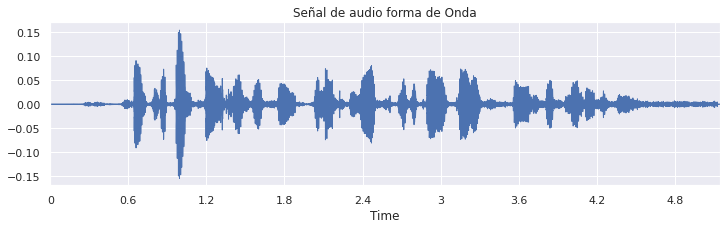

In [4]:
# Utilice este fragmento de código para suprimir todos los UserWarnings relacionados con 'librosa'
import warnings
warnings.filterwarnings("ignore")

# Import librosa
import librosa
x=d['path'][0]
# Carga el archivo mp3 con una frecuencia de muestreo específica, aquí 16kHz
y, sr = librosa.load("clips/%s" % d['path'][0], sr=16_000)

# Graficar la muestra almacenada en 'y'
from matplotlib import pyplot as plt
import librosa.display

plt.figure(figsize=(12, 3))
plt.title("Señal de audio forma de Onda")
librosa.display.waveplot(y, sr=sr);


Realizamos un zoom en una parte en especifico de la onda para poder visualizarla de mejor manera.

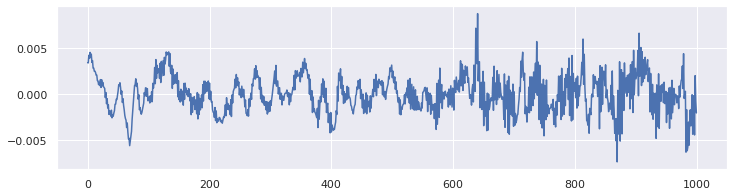

In [5]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 3))
plt.plot(y[17500:18500])
plt.show();


## **TRANSFORMADA DE FURIER**
Utilizando una transformación rápida de Fourier, podemos invertir esta cuestión y obtener una información clara sobre qué frecuencias están presentes, al tiempo que perdemos toda la información sobre el "cuando". En tal caso, se dice que la representación de la señal es en el dominio de la frecuencia.

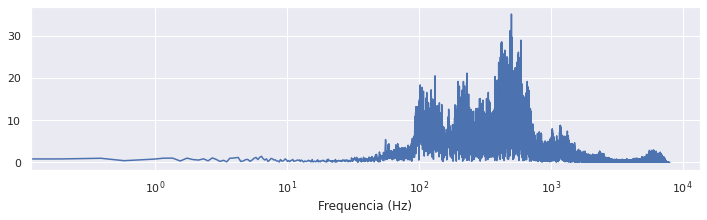

In [6]:
import scipy
import numpy as np

# Aplica la transformación rápida de Fourier a la señal y toma los valores absolutos
y_freq = np.abs(scipy.fftpack.fft(y))

# Establece todas las frecuencias posibles (en función de la frecuencia de muestreo y la longitud de la señal)
f = np.linspace(0, sr, len(y_freq))

# Graficar la señal de audio como información de frecuencia.
plt.figure(figsize=(12, 3))
plt.semilogx(f[: len(f) // 2], y_freq[: len(f) // 2])
plt.xlabel("Frequencia (Hz)")
plt.show();


## **TRANSFORMADA DE FOURIER DE TIEMPO CORTO (STFT)**
Usando una pequeña versión adaptada de la transformación rápida de Fourier anterior, a saber, la transformación de Fourier de tiempo corto (STFT), podemos crear un espectrograma de este tipo. El pequeño truco que se aplica aquí es que la FFT se calcula para múltiples ventanas de tiempo pequeñas (por lo tanto, "Fourier de tiempo corto") en forma de ventana deslizante.

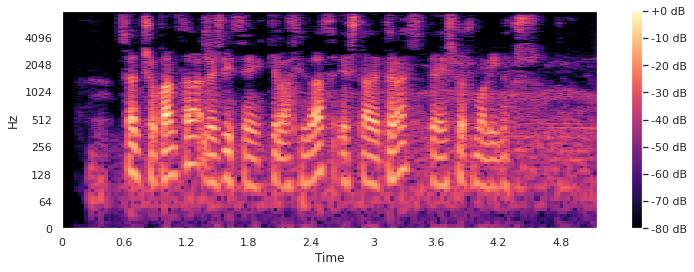

In [7]:
import librosa.display

# Calcular la transformada de Fourier de corta duración
x_stft = np.abs(librosa.stft(y))

# Aplica la escala logarítmica de dB al espectrograma y fija el máximo en 0 dB
x_stft = librosa.amplitude_to_db(x_stft, ref=np.max)

# Graficar espectrograma STFT
plt.figure(figsize=(12, 4))
librosa.display.specshow(x_stft, sr=sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.show();


## **ESPECTOGRAMA DE MEL**
Como alternativa a la STFT, también puede calcular el espectrograma mel, que se basa en la escala mel. Esta escala tiene en cuenta la forma en que los humanos percibimos el tono de un sonido. La escala mel se calcula de forma que dos pares de frecuencias separadas por un delta en la escala mel sean percibidas por los humanos como si tuvieran la misma diferencia perceptiva.

El espectrograma mel se calcula de forma muy similar a la STFT, la principal diferencia es que el eje y utiliza una escala diferente.


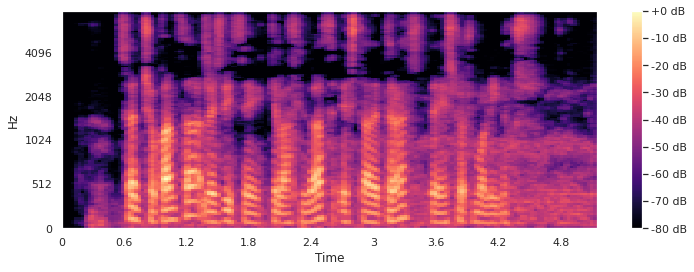

In [8]:
# Calcular el espectrograma mel
x_mel = librosa.feature.melspectrogram(y=y, sr=sr)

# Aplica la escala logarítmica de dB al espectrograma y fija el máximo en 0 dB
x_mel = librosa.power_to_db(x_mel, ref=np.max)

# Graficar espectrograma mel
plt.figure(figsize=(12, 4))
librosa.display.specshow(x_mel, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.show();


## **COEFICIENTES CEPSTRALES DE FRECUENCIA MEL**
Los coeficientes cepstrales de frecuencia mel (MFCC) son una representación alternativa del espectrograma mel anterior. La ventaja de los MFCC sobre el espectrograma mel es el número bastante reducido de características (es decir, líneas horizontales únicas), normalmente ~20.

Dado que el espectrograma mel se parece más a la forma en que los humanos percibimos el tono y que los MFCC sólo tienen unos pocos componentes, la mayoría de los profesionales del aprendizaje automático prefieren los MFCC para representar los datos de audio en forma de "imagen". Esto no quiere decir que, para un problema determinado, una representación STFT, mel o de forma de onda pueda funcionar mejor.








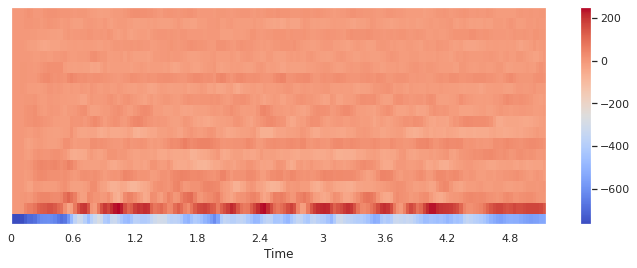

In [9]:
# Extraer 'n_mfcc' números de componentes MFCCs (aquí 20)
x_mfccs = librosa.feature.mfcc(y, sr=sr, n_mfcc=20)

# Graficar MFCCs
plt.figure(figsize=(12, 4))
librosa.display.specshow(x_mfccs, sr=sr, x_axis="time")
plt.colorbar()
plt.show();


# **VISUALIZACION DE DATOS**
Primeramente visualizaremos algunos archivos para ver su estructura

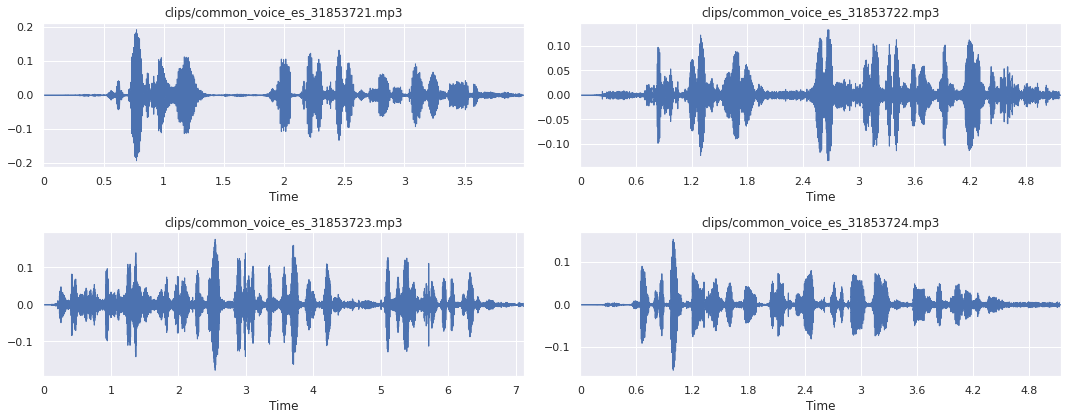

In [ ]:
# Visualización de cuatro archivos mp3
fig, axs = plt.subplots(2, 2, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    fname = "clips/common_voice_es_3185372%d.mp3" % (i + 1)
    y, sr = librosa.load(fname, sr=16_000)
    librosa.display.waveplot(y, sr=sr, ax=ax)
    ax.set_title(fname)
plt.tight_layout()
plt.show();


Se evidencia en las graficas de onda que el 3 tiene un ruido de fondo variable que cubre múltiples frecuencias, mientras que el ruido de fondo en la muestra 4 es bastante constante. Esto es también lo que vemos en las figuras de arriba. La muestra 3 es muy ruidosa en todo momento, mientras que la muestra 4 es ruidosa solo en unas pocas frecuencias.




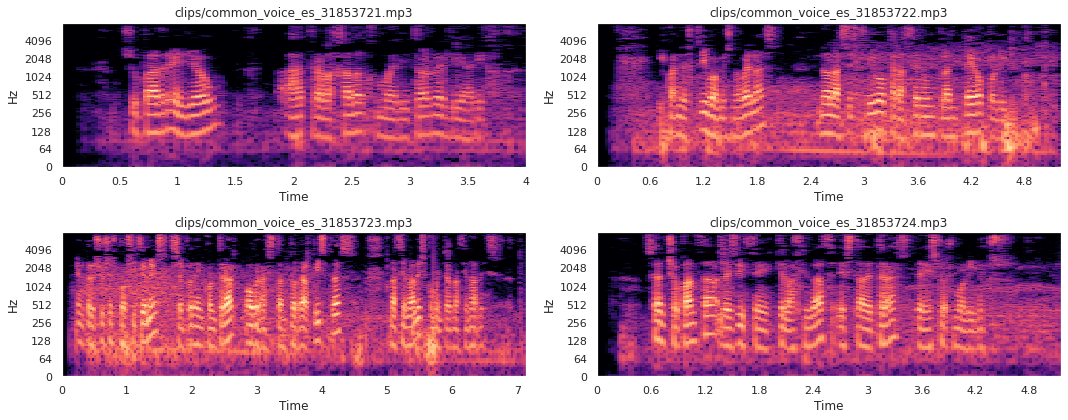

In [ ]:
# El código es el mismo que antes, utilizando la rutina stft-spectrogram
fig, axs = plt.subplots(2, 2, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    fname = "clips/common_voice_es_3185372%d.mp3" % (i + 1)
    y, sr = librosa.load(fname, sr=16_000)
    x_stft = np.abs(librosa.stft(y))
    x_stft = librosa.amplitude_to_db(x_stft, ref=np.max)
    librosa.display.specshow(x_stft, sr=sr, x_axis="time", y_axis="log", ax=ax)
    ax.set_title(fname)
plt.tight_layout()
plt.show();


# **PREPARACION Y LIMPIEZA DE AUDIOS**

Se realizo una preparacion de los datos porque se necesitaba extraer unas caracteristicas importantes como lo son: la duracion , el tempo , las palabras por minutos , la cantidad de palabras.

tambien se muestra una representacion en forma de onda de la oracion hablada.

Se procede entonces a eliminar el ruido de las muestras.

In [ ]:
import noisereduce as nr
from scipy.io import wavfile

# Bucle a través de las cuatro muestras
for i in range(d.shape[0]):

    # Cargar archivo de audio
    fname = "clips/%s" % d['path'][i]
    y, sr = librosa.load(fname, sr=16_000)
    
    # Eliminar el ruido de una muestra de audio
    reduced_noise = nr.reduce_noise(y=y, sr=sr, stationary=False)

    # Guardar la salida en un archivo wav como mp3 no se puede guardar en directamente
    wavfile.write(fname.replace(".mp3", ".wav"), sr, reduced_noise)


Para el paso de recorte podemos usar `.effects.trim()` la función de librosa. Tenga en cuenta que cada conjunto de datos puede necesitar un `top_db` parámetro diferente para el recorte, por lo que lo mejor es probar algunas versiones y ver qué funciona bien. En nuestro caso lo es `top_db=20`.

In [ ]:
# Bucle a través de las cuatro muestras
for i in range(d.shape[0]):

    # Cargar archivo de audio
    fname = "clips/%s" % d['path'][i]
    y, sr = librosa.load(fname, sr=16_000)
   
    # Señal de ajuste
    y_trim, _ = librosa.effects.trim(y, top_db=20)

    # Overwrite previous wav file
    wavfile.write(fname.replace(".mp3", ".wav"), sr, y_trim)


visualizamos el resultado de los datos.

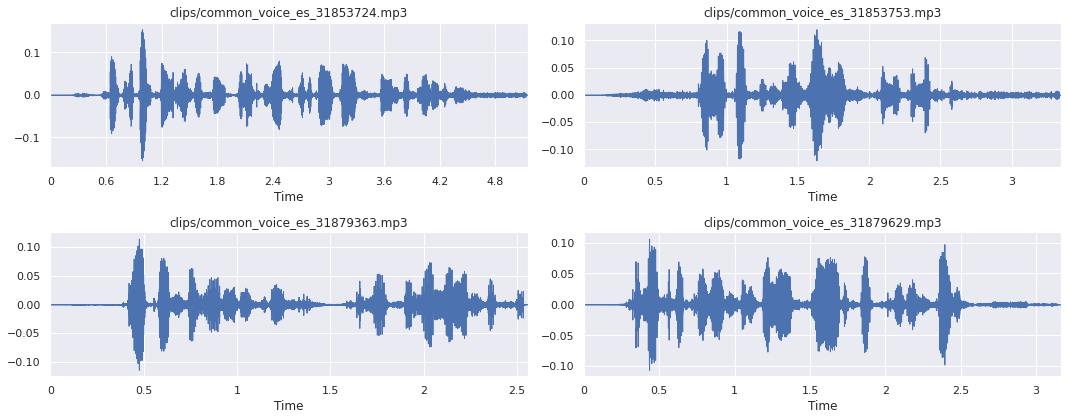

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    fname = "clips/%s" % d['path'][i]
    y, sr = librosa.load(fname, sr=16_000)
    librosa.display.waveplot(y, sr=sr, ax=ax)
    ax.set_title(fname)
    i=i+1
plt.tight_layout()
plt.show();


# **EXTRACION DE CARACTERISTICAS IMPORTANTES AL DATAFRAME**

## ***Agregando columnas necesarias para el entrenamiento, eliminando las columnas innecesarias***

In [ ]:
d2=d
d2['nwords']=0
d2['duration']=0
d2['wps']=0
d2['tempo']=0
d2['f0_mean']=0
d2['f0_median']=0
d2['f0_std']=0
d2['f0_5perc']=0
d2['f0_95perc']=0

del d2['down_votes']
del d2['up_votes']
del d2['sentence']
del d2['segment']
del d2['locale']
del d2['accents']
del d2['client_id']

d2.head()

,path,age,gender,nwords,duration,wps,tempo,f0_mean,f0_median,f0_std,f0_5perc,f0_95perc
0,common_voice_es_31853724.mp3,fourties,male,0,0,0,0,0,0,0,0,0
1,common_voice_es_31853753.mp3,fourties,male,0,0,0,0,0,0,0,0,0
2,common_voice_es_31879363.mp3,fourties,male,0,0,0,0,0,0,0,0,0
3,common_voice_es_31879629.mp3,fourties,male,0,0,0,0,0,0,0,0,0
4,common_voice_es_31879738.mp3,fourties,male,0,0,0,0,0,0,0,0,0


## ***Deteccion de inicio, duracion de audio, tempo***

Aqui se detecta cada una de las palabras habladas para poderlas contar, se calcula la velocidad y duracion de cada muestra, extraemos el tempo; posteriormente hacemos la extraccion de la frecuencia fundamental, la cual nos permite extraer aun mas caracteristicas.

In [ ]:
for i in range(d2.shape[0]):
  # Load data
  y, sr = librosa.load("clips/%s" % d['path'][i], sr=16_000)

  # Extract onset timestamps of words
  onsets = librosa.onset.onset_detect(
      y=y, sr=sr, units="time", hop_length=128, backtrack=False)

  # Return number of onsets
  number_of_words = len(onsets)
  d2.loc[i,'nwords']=number_of_words

  # Computes duration in seconds
  duration = len(y) / sr
  words_per_second = number_of_words / duration
  d2.loc[i,'wps']=words_per_second
  d2.loc[i,'duration']=duration

  # Computes the tempo of a audio recording
  tempo = librosa.beat.tempo(y, sr, start_bpm=10)[0]
  d2.loc[i,'tempo']=float('%.2f' % tempo)
  

d2.head()

,path,age,gender,nwords,duration,wps,tempo,f0_mean,f0_median,f0_std,f0_5perc,f0_95perc
0,common_voice_es_31853724.mp3,fourties,male,30,5.148,5.827506,25.68,0,0,0,0,0
1,common_voice_es_31853753.mp3,fourties,male,17,3.348,5.077658,24.67,0,0,0,0,0
2,common_voice_es_31879363.mp3,fourties,male,14,2.556,5.477308,32.33,0,0,0,0,0
3,common_voice_es_31879629.mp3,fourties,male,18,3.168,5.681818,29.30,0,0,0,0,0
4,common_voice_es_31879738.mp3,fourties,male,21,3.456,6.076389,18.20,0,0,0,0,0


In [ ]:
for i in range(d2.shape[0]):
  # Load data
  y, sr = librosa.load("clips/%s" % d['path'][i], sr=16_000)

  # Extract fundamental frequency using a probabilistic approach
  f0, _, _ = librosa.pyin(y, sr=sr, fmin=10, fmax=8000, frame_length=1024)

  # Computes mean, median, 5%- and 95%-percentile value of fundamental frequency
  f0_values = [
    np.nanmean(f0),
    np.nanmedian(f0),
    np.nanstd(f0),
    np.nanpercentile(f0, 5),
    np.nanpercentile(f0, 95),
  ]
  d2.loc[i,'f0_mean']=float('%.2f' % f0_values[0])
  d2.loc[i,'f0_median']=float('%.2f' % f0_values[1])
  d2.loc[i,'f0_std']=float('%.2f' % f0_values[2])
  d2.loc[i,'f0_5perc']=float('%.2f' % f0_values[3])
  d2.loc[i,'f0_95perc']=float('%.2f' % f0_values[4])





In [ ]:
d2.head()

,path,age,gender,nwords,duration,wps,tempo,f0_mean,f0_median,f0_std,f0_5perc,f0_95perc
0,common_voice_es_31853724.mp3,fourties,male,30,5.148,5.827506,25.68,103.67,103.15,28.78,46.75,158.18
1,common_voice_es_31853753.mp3,fourties,male,17,3.348,5.077658,24.67,121.03,116.12,22.92,95.52,172.53
2,common_voice_es_31879363.mp3,fourties,male,14,2.556,5.477308,32.33,124.08,121.96,20.25,101.96,163.04
3,common_voice_es_31879629.mp3,fourties,male,18,3.168,5.681818,29.30,222.08,127.36,177.24,103.42,546.16
4,common_voice_es_31879738.mp3,fourties,male,21,3.456,6.076389,18.20,98.68,110.55,31.70,42.62,135.32


In [ ]:
# Map age to appropriate numerical value
d.loc[:, "age"] = d["age"].map({
        "teens": 1,
        "twenties": 2,
        "thirties": 3,
        "fourties": 4,
        "fifties": 5,
        "sixties": 6})

# Map gender to corresponding numerical value
d.loc[:, "gender"] = d["gender"].map({"male": 0, "female": 1})


In [ ]:
d2=d
d2.head()

,path,age,gender,nwords,duration,wps,tempo,f0_mean,f0_median,f0_std,f0_5perc,f0_95perc
0,common_voice_es_31853724.mp3,4,0,30,5.148,5.827506,25.68,103.67,103.15,28.78,46.75,158.18
1,common_voice_es_31853753.mp3,4,0,17,3.348,5.077658,24.67,121.03,116.12,22.92,95.52,172.53
2,common_voice_es_31879363.mp3,4,0,14,2.556,5.477308,32.33,124.08,121.96,20.25,101.96,163.04
3,common_voice_es_31879629.mp3,4,0,18,3.168,5.681818,29.30,222.08,127.36,177.24,103.42,546.16
4,common_voice_es_31879738.mp3,4,0,21,3.456,6.076389,18.20,98.68,110.55,31.70,42.62,135.32


# **Caracteristicas se desean clasificar**

Primero, veamos las distribuciones de clase de nuestras clases objetivo potenciales `age` y `gender`.

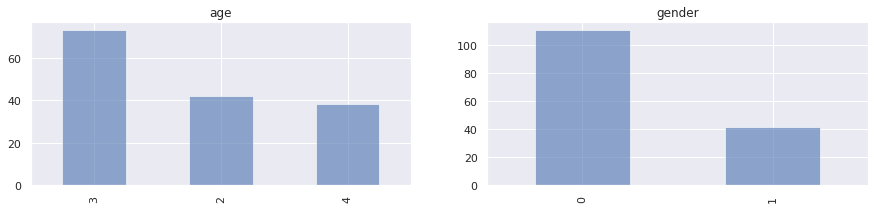

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 3))
for i, c in enumerate(["age", "gender"]):
    d2[c].value_counts().plot.bar(title=c, ax=axes[i], alpha=0.6)
plt.show();


## **caracteristicas extraidas**

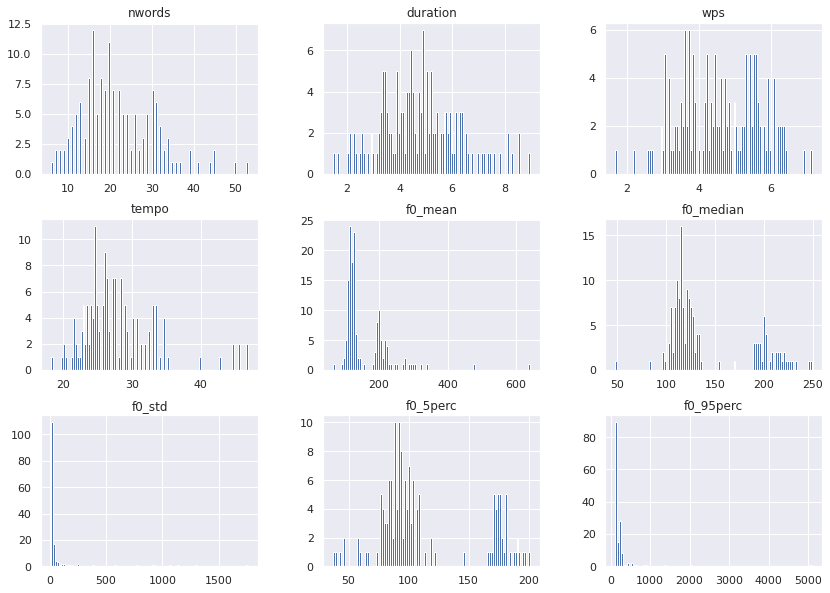

In [ ]:
# Plot value distributions of extracted features
d2.drop(columns=["age", "gender", "path"]).hist(bins=100, figsize=(14, 10))
plt.show();


A excepción de words_per_second, la mayoría de estas distribuciones de características están sesgadas hacia la derecha y, por lo tanto, podrían beneficiarse de una transformación logarítmica. Así que cuidémonos de eso.

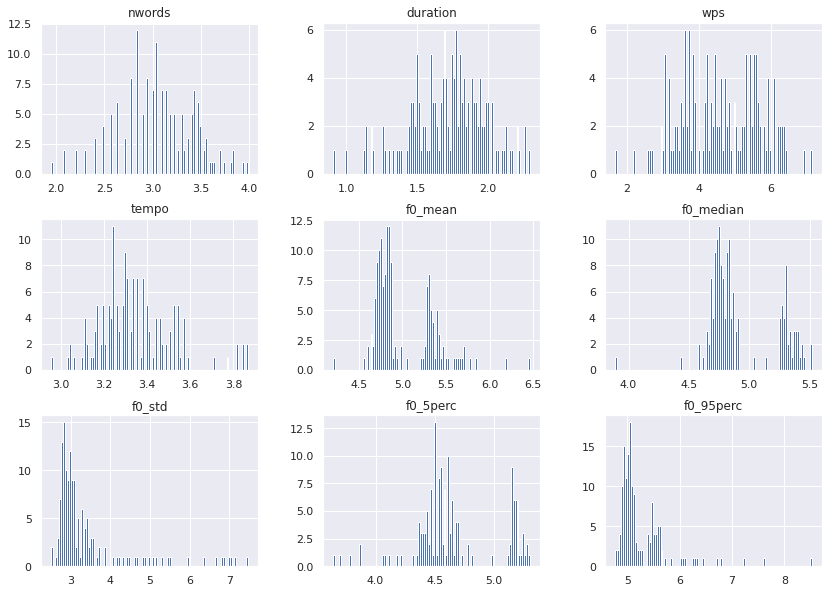

In [ ]:
import numpy as np

# Applies log1p on features that are not age, gender, path or wps
d2 = d2.apply(
    lambda x: np.log1p(x)
    if x.name not in ["age", "gender", "path", "wps"]
    else x)

# Let's look at the distribution once more
d2.drop(columns=["age", "gender", "path"]).hist(bins=100, figsize=(14, 10))
plt.show();


lo interesante es el hecho de que f0todas las características parecen tener una distribución bimodal. Grafiquemos lo mismo que antes, pero esta vez separados por género.

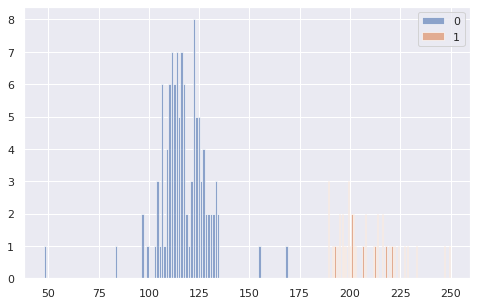

In [ ]:
for g in d2.gender.unique():
    d2[d2["gender"].eq(g)]["f0_median"].hist(
        bins=100, figsize=(8, 5), label=g, alpha=0.6)
plt.legend()
plt.show();


In [ ]:
print(d["gender"].value_counts())

0    111
1     42
Name: gender, dtype: int64


Como se sospechaba, ¡parece haber un efecto de género aquí! Pero lo que también podemos ver es que algunas `f0` puntuaciones (aquí en particular en los varones) son mucho más bajas y más altas de lo que deberían ser. Estos podrían ser valores atípicos, debido a una mala extracción de características. Echemos un vistazo más de cerca a todos los puntos de datos con la siguiente figura.

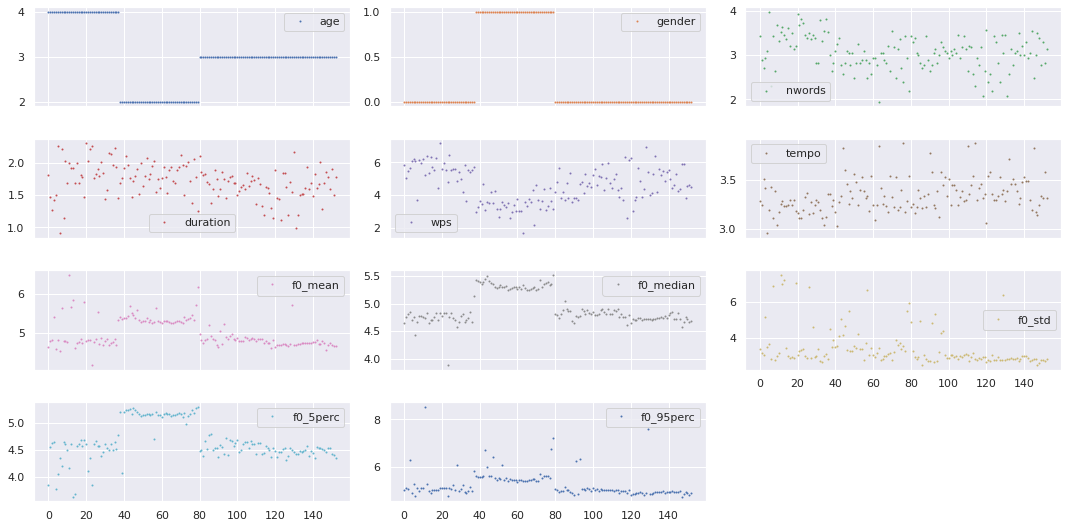

In [ ]:
# Plot sample points for each feature individually
d2.plot(lw=0, marker=".", subplots=True, layout=(-1, 3),
        figsize=(15, 7.5), markersize=2)
plt.tight_layout()
plt.show();

Dada la poca cantidad de funciones y el hecho de que tenemos distribuciones bastante atractivas con colas pronunciadas, podríamos revisar cada una de ellas y decidir el umbral de corte atípico característica por característica. Pero para mostrarle una forma más automatizada, usemos un enfoque de puntuación z en su lugar.

In [ ]:
from scipy.stats import zscore

# Only select columns with numbers from the dataframe
d2_num = d2.select_dtypes(np.number)

# Apply zscore to all numerical features
d2_num = d2_num.apply(zscore)

# Identify all samples that are below a specific z-value
z_thresh = 3
mask = np.sum(d2_num.abs() > z_thresh, axis=1).eq(0)

# Only keep the values in the mask
d2 = d2[mask]
d2.shape

(140, 12)

## **Mapa de Correlacion**

Como siguiente paso, echemos un vistazo a la correlación entre todas las características. Pero antes de que podamos hacer eso, avancemos y codifiquemos también las características de destino no numéricas haciendo un mapeo manual.

In [ ]:
# Map age to appropriate numerical value
d2.loc[:, "age"] = d2["age"].map({
        "teens": 1,
        "twenties": 2,
        "thirties": 3,
        "fourties": 4,
        "fifties": 5,
        "sixties": 6})

# Map gender to corresponding numerical value
d2.loc[:, "gender"] = d2["gender"].map({"male": 0, "female": 1})

Ahora estamos listos para usar `.corr()` la función pandas junto con la de seaborn `heatmap()` para obtener más información sobre la correlación de características.

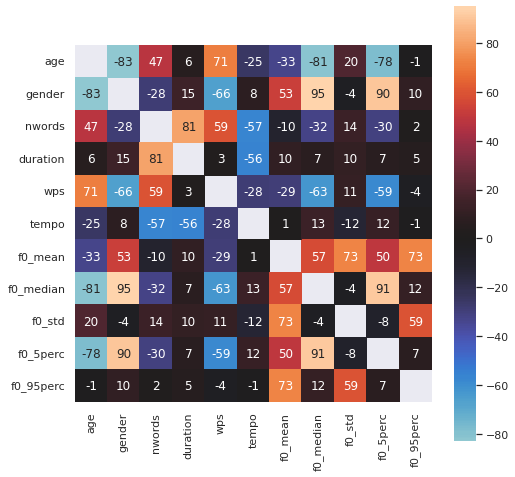

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 8))
df_corr = d2.corr() * 100
sns.heatmap(df_corr, square=True, annot=True, fmt=".0f",
            mask=np.eye(len(df_corr)), center=0)
plt.show();

¡Interesante! Lo que podemos ver es que nuestras `f0` características extraídas parecen tener una relación bastante fuerte con genderel objetivo, mientras que ageno parece correlacionarse mucho con nada.

## **Características del espectrograma**
En este momento, no hemos revisado las grabaciones de audio reales en nuestro análisis exploratorio de datos (EDA). Como se mencionó previamente, tenemos varias opciones de representación de audio, como forma de onda o espectrograma STFT, mel o mfccs. Para esta exploración en particular, continuaremos utilizando los espectrogramas de mel.

No obstante, antes de poder hacerlo, debemos tomar en cuenta un factor importante: las muestras de audio tienen diferentes longitudes, lo que se traduce en espectrogramas de diferentes longitudes. Para normalizar todas las grabaciones, las cortaremos a una duración de exactamente 3 segundos. Es decir, las muestras demasiado cortas se alargarán y las muestras demasiado largas se recortarán.

In [ ]:
# Two helper functions for audio data preparation

import os
import librosa

def resize_spectrogram(spec, length, fact=-80):

    # Create an empty canvas to put spectrogram into
    canvas = np.ones((len(spec), length)) * fact

    if spec.shape[1] <= length:
        canvas[:, : spec.shape[1]] = spec
    else:
        canvas[:, :length] = spec[:, :length]
    return canvas

def compute_mel_spec(filename, sr=16_000, hop_length=512, duration=3.0):

    # Loads the mp3 file
    y, sr = librosa.load(os.path.join("clips", filename), sr=sr)

    # Compute the mel spectrogram
    x_mel = librosa.feature.melspectrogram(y=y, sr=sr)

    # Apply logarithmic dB-scale to spectrogram and set maximum to 0 dB
    x_mel = librosa.power_to_db(x_mel, ref=np.max)

    # Compute mean strength per frequency for mel spectrogram
    mel_strength = np.mean(x_mel, axis=1)

    # Estimate the desired length of the spectrogram
    length = int(duration * sr / hop_length)

    # Put mel spectrogram into the right shape
    x_mel = resize_spectrogram(x_mel, length, fact=-80)

    return x_mel, mel_strength

Ahora que todo está listo, extraigamos los espectrogramas para todas las muestras de audio.

In [ ]:
from tqdm.notebook import tqdm

d2.dropna(inplace=True)

# Create arrays to store output into
spec_infos = []

# Loop through all files and extract spectrograms
sr = 16_000
for f in tqdm(d2.path):
    spec_infos.append(compute_mel_spec(f, sr=sr))

# Aggregate feature types in common variable
mels = np.array([s[0] for s in spec_infos])
mels_strengths = np.array([s[1] for s in spec_infos])

  0%|          | 0/153 [00:00<?, ?it/s]

Ahora que también tenemos estas funciones de espectrograma, ¡realicemos algo de EDA en ellas también! Y como vimos que el 'género' parece tener una relación especial con nuestras grabaciones de audio, visualicemos el espectrograma de mel promedio para ambos géneros por separado, así como sus diferencias.

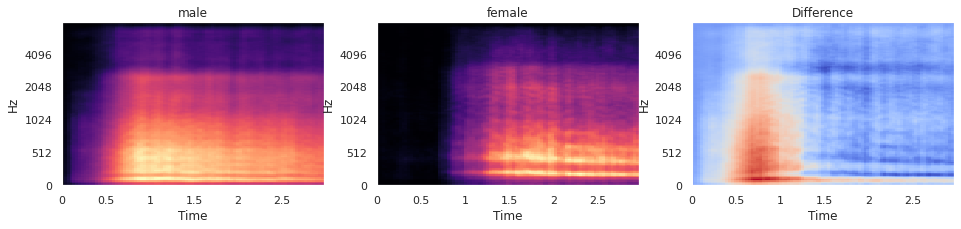

In [ ]:
import librosa.display

# Creates a figure with two subplot
fig, axs = plt.subplots(1, 3, figsize=(16, 3))

# Plots mel spectrogram for male speakers
mels_male = np.mean(mels[d2["gender"].eq(0)], axis=0)
librosa.display.specshow(mels_male, sr=sr, x_axis="time", y_axis="mel", ax=axs[0])
axs[0].set_title("male")

# Plots mel spectrogram for female speakers
mels_female = np.mean(mels[d2["gender"].eq(1)], axis=0)
librosa.display.specshow(mels_female, sr=sr, x_axis="time", y_axis="mel", ax=axs[1])
axs[1].set_title("female")

# Plot gender differences
librosa.display.specshow(
    mels_male - mels_female, sr=sr, x_axis="time", y_axis="mel", ax=axs[2]
)
axs[2].set_title("Difference")
plt.show()



# **Evaluacion del DataSet con estimadores: para la edad**
Tomemos los datos del archivo CSV y hacemos uso de los modelos GNB, RandomForest, SVC para ver hasta qué punto podemos predecir la edad de un hablante. Para empezar, carguemos los datos y dividámoslos en un conjunto de entrenamiento y otro de prueba.

###### **separacion de entrenamiento y prueba**

In [ ]:
from sklearn.model_selection import train_test_split

# Select target
target = "age"
y = d2[target].values

# Select relevant features from the dataframe
features = d2.drop(columns=["path", target]).reset_index(drop=True)

# Combine them with the mels strength features
X = pd.concat((features, pd.DataFrame(mels_strengths)), axis=1)

# Create train and test set
x_tr, x_te, y_tr, y_te = train_test_split(
    X, y, train_size=0.8, shuffle=True, stratify=y, random_state=0
)

# Plot size of dataset
print(x_tr.shape)

(15, 138)


###### **GaussianNB**

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Create a Gaussian Naive Bayes model
gnb = GaussianNB()

# Train the model on the training set
gnb.fit(x_tr, y_tr)

# Predict on the test set
y_pred = gnb.predict(x_te)


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Compute accuracy, precision, recall and confusion matrix
acc = accuracy_score(y_te, y_pred)
prec = precision_score(y_te, y_pred, average='macro')
rec = recall_score(y_te, y_pred, average='macro')
cm = confusion_matrix(y_te, y_pred)

# Perform cross-validation
scores = cross_val_score(gnb, X, y, cv=5)

# Print the results
print("Cross-validation scores:")
print(scores)
print(f"Mean score: {scores.mean():.3f}")
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"Confusion Matrix:\n{cm}")

Cross-validation scores:
[0.96774194 0.96774194 0.80645161 0.83333333 0.83333333]
Mean score: 0.882
Accuracy: 0.877
Precision: 0.873
Recall: 0.886
Confusion Matrix:
[[38  0  0]
 [ 0 55 11]
 [ 0  6 28]]


In [ ]:
from sklearn.metrics import classification_report

# Hacer predicciones en el conjunto de prueba
y_pred = gnb.predict(x_te)

# Mostrar el classification report
print(classification_report(y_te, y_pred))

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        38
           3       0.90      0.83      0.87        66
           4       0.72      0.82      0.77        34

    accuracy                           0.88       138
   macro avg       0.87      0.89      0.88       138
weighted avg       0.88      0.88      0.88       138



###### **RandomForest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(x_tr, y_tr)

# Make predictions on the test set
y_pred = rf_model.predict(x_te)

# Compute accuracy, precision, recall and confusion matrix
acc = accuracy_score(y_te, y_pred)
prec = precision_score(y_te, y_pred, average='macro')
rec = recall_score(y_te, y_pred, average='macro')
cm = confusion_matrix(y_te, y_pred)

# Perform cross-validation
scores = cross_val_score(rf_model, X, y, cv=5)

# Print the results
print("Cross-validation scores:")
print(scores)
print(f"Mean score: {scores.mean():.3f}")
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"Confusion Matrix:\n{cm}")

Cross-validation scores:
[0.96774194 1.         1.         1.         0.9       ]
Mean score: 0.974
Accuracy: 0.891
Precision: 0.911
Recall: 0.870
Confusion Matrix:
[[35  3  0]
 [ 0 63  3]
 [ 0  9 25]]


In [ ]:
from sklearn.metrics import classification_report

# Hacer predicciones en el conjunto de prueba
y_pred = rf_model.predict(x_te)

# Mostrar el classification report
print(classification_report(y_te, y_pred))

              precision    recall  f1-score   support

           2       1.00      0.92      0.96        38
           3       0.84      0.95      0.89        66
           4       0.89      0.74      0.81        34

    accuracy                           0.89       138
   macro avg       0.91      0.87      0.89       138
weighted avg       0.90      0.89      0.89       138



###### **SVC**

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Seleccionar la variable objetivo
target = "age"
y = d2[target].values

# Seleccionar las características relevantes del marco de datos
features = d2.drop(columns=["path", target]).reset_index(drop=True)

# Combinarlas con las características de la fuerza de los mels
X = pd.concat((features, pd.DataFrame(mels_strengths)), axis=1)

# Crear un conjunto de entrenamiento y prueba
x_tr, x_te, y_tr, y_te = train_test_split(
    X, y, train_size=0.8, shuffle=True, stratify=y, random_state=0
)

# Definir los kernels para probar
kernels = ['rbf', 'poly', 'linear', 'sigmoid']

# Iterar a través de cada kernel y entrenar el modelo
for kernel in kernels:
    # Inicializar el modelo SVC con el kernel actual
    svc_model = SVC(kernel=kernel)

    # Entrenar el modelo
    svc_model.fit(x_tr, y_tr)

    # Hacer predicciones sobre el conjunto de prueba
    y_pred = svc_model.predict(x_te)

    # Calcular la puntuación de precisión
    accuracy = accuracy_score(y_te, y_pred)

    # Imprimir la puntuación de precisión y el classification_report
    print(f"Kernel: {kernel}")
    print(f"Puntuación de precisión: {accuracy:.3f}")
    print(classification_report(y_te, y_pred))

Kernel: rbf
Puntuación de precisión: 0.710
              precision    recall  f1-score   support

           2       1.00      0.88      0.93         8
           3       0.65      1.00      0.79        15
           4       0.00      0.00      0.00         8

    accuracy                           0.71        31
   macro avg       0.55      0.62      0.57        31
weighted avg       0.57      0.71      0.62        31

Kernel: poly
Puntuación de precisión: 0.742
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         8
           3       0.65      1.00      0.79        15
           4       0.00      0.00      0.00         8

    accuracy                           0.74        31
   macro avg       0.55      0.67      0.60        31
weighted avg       0.57      0.74      0.64        31

Kernel: linear
Puntuación de precisión: 0.968
              precision    recall  f1-score   support

           2       1.00      1.00      1.00       

###### **RED NEURONAL**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# Seleccionar la variable objetivo
target = "age"
y = d2[target].values

# Seleccionar las características relevantes del marco de datos
features = d2.drop(columns=["path", target]).reset_index(drop=True)

# Combinarlas con las características de la fuerza de los mels
X = pd.concat((features, pd.DataFrame(mels_strengths)), axis=1)

# Crear un conjunto de entrenamiento y prueba
x_tr, x_te, y_tr, y_te = train_test_split(
    X, y, train_size=0.8, shuffle=True, stratify=y, random_state=0
)

# Crear el modelo de la red neuronal
model = keras.Sequential(
    [
        layers.Dense(256, activation="relu", input_shape=(X.shape[1],)),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="linear")
    ]
)

# Compilar el modelo
model.summary()
model.compile(loss="mse", optimizer="adam", metrics=["mae"])

# Entrenar el modelo
model.fit(x_tr, y_tr, validation_split=0.2, epochs=100, batch_size=16, verbose=0)

# Evaluar el modelo con los datos de prueba
mse, mae = model.evaluate(x_te, y_te, verbose=0)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 256)               35584     
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 78,849
Trainable params: 78,849
Non-trainable params: 0
_________________________________________________________________
Mean Squared Error: 0.2721770703792572
Mean Absolu

Este código a evaluar el rendimiento del modelo de red neuronal en el conjunto de datos de prueba y para calcular los errores de predicción.

MSE o Mean Squared Error es una métrica de regresión que mide el promedio de los errores al cuadrado entre el valor predicho y el valor verdadero. Es decir, toma la diferencia entre cada predicción y su valor real, eleva la diferencia al cuadrado y promedia los resultados. Es una medida de la magnitud del error cuadrático medio y su unidad es el cuadrado de la unidad de los datos de destino. Una puntuación más baja de MSE indica una mejor calidad de las predicciones.

MAE o Mean Absolute Error es otra métrica de regresión que mide el promedio de las diferencias absolutas entre el valor predicho y el valor verdadero. Es decir, toma la diferencia entre cada predicción y su valor real, toma el valor absoluto de la diferencia y promedia los resultados. Es una medida de la magnitud del error absoluto medio y su unidad es la misma que la unidad de los datos de destino. Una puntuación más baja de MAE indica una mejor calidad de las predicciones.

# **Evaluacion del DataSet con estimadores: para el genero**
Tomemos los datos del archivo CSV y hacemos uso de los modelos GNB, RandomForest, SVC para ver hasta qué punto podemos predecir el genero de un hablante. Para empezar, carguemos los datos y dividámoslos en un conjunto de entrenamiento y otro de prueba.

###### **separacion de entrenamiento y prueba**

In [ ]:
from sklearn.model_selection import train_test_split

# Select target
target = "gender"
y = d2[target].values

# Select relevant features from the dataframe
features = d2.drop(columns=["path", target]).reset_index(drop=True)

# Combine them with the mels strength features
X = pd.concat((features, pd.DataFrame(mels_strengths)), axis=1)

# Create train and test set
x_tr, x_te, y_tr, y_te = train_test_split(
    X, y, train_size=0.8, shuffle=True, stratify=y, random_state=0
)

# Plot size of dataset
print(x_tr.shape)

(15, 138)


###### **GaussianNB**

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Create a Gaussian Naive Bayes model
gnb = GaussianNB()

# Train the model on the training set
gnb.fit(x_tr, y_tr)

# Predict on the test set
y_pred = gnb.predict(x_te)


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Compute accuracy, precision, recall and confusion matrix
acc = accuracy_score(y_te, y_pred)
prec = precision_score(y_te, y_pred, average='macro')
rec = recall_score(y_te, y_pred, average='macro')
cm = confusion_matrix(y_te, y_pred)

# Perform cross-validation
scores = cross_val_score(gnb, X, y, cv=5)

# Print the results
print("Cross-validation scores:")
print(scores)
print(f"Mean score: {scores.mean():.3f}")
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"Confusion Matrix:\n{cm}")

Cross-validation scores:
[1.         1.         1.         0.96666667 0.96666667]
Mean score: 0.987
Accuracy: 0.986
Precision: 0.982
Recall: 0.982
Confusion Matrix:
[[99  1]
 [ 1 37]]


In [ ]:
from sklearn.metrics import classification_report

# Hacer predicciones en el conjunto de prueba
y_pred = gnb.predict(x_te)

# Mostrar el classification report
print(classification_report(y_te, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       100
           1       0.97      0.97      0.97        38

    accuracy                           0.99       138
   macro avg       0.98      0.98      0.98       138
weighted avg       0.99      0.99      0.99       138



###### **RandomForest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(x_tr, y_tr)

# Make predictions on the test set
y_pred = rf_model.predict(x_te)

# Compute accuracy, precision, recall and confusion matrix
acc = accuracy_score(y_te, y_pred)
prec = precision_score(y_te, y_pred, average='macro')
rec = recall_score(y_te, y_pred, average='macro')
cm = confusion_matrix(y_te, y_pred)

# Perform cross-validation
scores = cross_val_score(rf_model, X, y, cv=5)

# Print the results
print("Cross-validation scores:")
print(scores)
print(f"Mean score: {scores.mean():.3f}")
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"Confusion Matrix:\n{cm}")

Cross-validation scores:
[1. 1. 1. 1. 1.]
Mean score: 1.000
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
Confusion Matrix:
[[100   0]
 [  0  38]]


In [ ]:
from sklearn.metrics import classification_report

# Hacer predicciones en el conjunto de prueba
y_pred = rf_model.predict(x_te)

# Mostrar el classification report
print(classification_report(y_te, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00        38

    accuracy                           1.00       138
   macro avg       1.00      1.00      1.00       138
weighted avg       1.00      1.00      1.00       138



###### **SVC**

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Seleccionar la variable objetivo
target = "gender"
y = d2[target].values

# Seleccionar las características relevantes del marco de datos
features = d2.drop(columns=["path", target]).reset_index(drop=True)

# Combinarlas con las características de la fuerza de los mels
X = pd.concat((features, pd.DataFrame(mels_strengths)), axis=1)

# Crear un conjunto de entrenamiento y prueba
x_tr, x_te, y_tr, y_te = train_test_split(
    X, y, train_size=0.8, shuffle=True, stratify=y, random_state=0
)

# Definir los kernels para probar
kernels = ['rbf', 'poly', 'linear']

# Iterar a través de cada kernel y entrenar el modelo
for kernel in kernels:
    # Inicializar el modelo SVC con el kernel actual
    svc_model = SVC(kernel=kernel)

    # Entrenar el modelo
    svc_model.fit(x_tr, y_tr)

    # Hacer predicciones sobre el conjunto de prueba
    y_pred = svc_model.predict(x_te)

    # Calcular la puntuación de precisión
    accuracy = accuracy_score(y_te, y_pred)

    # Imprimir la puntuación de precisión y el classification_report
    print(f"Kernel: {kernel}")
    print(f"Puntuación de precisión: {accuracy:.3f}")
    print(classification_report(y_te, y_pred))

Kernel: rbf
Puntuación de precisión: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00         9

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31

Kernel: poly
Puntuación de precisión: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00         9

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31

Kernel: linear
Puntuación de precisión: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00         9

    accuracy                           1.00      

###### **RED NEURONAL**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# Seleccionar la variable objetivo
target = "gender"
y = d2[target].values

# Seleccionar las características relevantes del marco de datos
features = d2.drop(columns=["path", target]).reset_index(drop=True)

# Combinarlas con las características de la fuerza de los mels
X = pd.concat((features, pd.DataFrame(mels_strengths)), axis=1)

# Crear un conjunto de entrenamiento y prueba
x_tr, x_te, y_tr, y_te = train_test_split(
    X, y, train_size=0.8, shuffle=True, stratify=y, random_state=0
)

# Crear el modelo de la red neuronal
model = keras.Sequential(
    [
        layers.Dense(256, activation="relu", input_shape=(X.shape[1],)),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="linear")
    ]
)

# Compilar el modelo
model.summary()
model.compile(loss="mse", optimizer="adam", metrics=["mae"])

# Entrenar el modelo
model.fit(x_tr, y_tr, validation_split=0.2, epochs=100, batch_size=16, verbose=0)

# Evaluar el modelo con los datos de prueba
mse, mae = model.evaluate(x_te, y_te, verbose=0)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 256)               35584     
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 dense_24 (Dense)            (None, 1)                 33        
                                                                 
Total params: 78,849
Trainable params: 78,849
Non-trainable params: 0
_________________________________________________________________
Mean Squared Error: 0.15719324350357056
Mean Absol

# REFERENCIAS


*   DataSet tomado de common mozilla voice: https://commonvoice.mozilla.org/es/datasets 
* Fuente de apoyo para la visualizacion de datos: https://es.linkedin.com/pulse/biometr%C3%ADa-de-voz-con-librosa-y-cnn-msc-guillermo-acha-ruiz

